In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rajumavinmar/finger-print-based-blood-group-dataset")

print("Path to dataset files:", path)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 58.1M/58.1M [00:21<00:00, 2.81MB/s]

Extracting files...


Path to dataset files: /Users/akmishra/.cache/kagglehub/datasets/rajumavinmar/finger-print-based-blood-group-dataset/versions/1


In [70]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
import numpy as np
import os
import shutil
from sklearn.utils import resample
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [5]:
dataset_path = "/Users/akmishra/.cache/kagglehub/datasets/rajumavinmar/finger-print-based-blood-group-dataset/versions/1/dataset_blood_group"

In [10]:
# Load the dataset
dataset = image_dataset_from_directory(
    dataset_path,
    labels='inferred',
    label_mode = 'int',
    image_size = (64,64),
    batch_size = 32,
    shuffle = True
)

Found 6000 files belonging to 8 classes.


In [11]:
class_names = dataset.class_names

In [17]:
for sample in dataset.take(10):
    print(sample[0].shape)

(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)


2025-03-11 22:41:55.722132: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [18]:
# now to split into training and testing we will unbatch the complete datset
unbatched_data = dataset.unbatch()

In [34]:
dataset_size = sum(1 for _ in unbatched_data)
print(dataset_size)

6000


In [40]:
train_size = int(0.7 * dataset_size)
val_size = int(0.3 * dataset_size)


In [89]:
train_data = unbatched_data.take(train_size)
val_data = unbatched_data.take(val_size)
test_data = unbatched_data.skip(val_size)

In [90]:
# Rebatching the dataset after splitting
train = train_data.batch(32, drop_remainder=True)
valid = val_data.batch(32, drop_remainder=True)
test = test_data.batch(32, drop_remainder=True)

In [45]:
train_data_count = sum(1 for _ in train)
val_data_count = sum(1 for _ in valid)
# test_data_count = sum(1 for _ in test)

print(train_data_count * 32,val_data_count * 32)

4192 1792


In [ ]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(len(class_names), activation='softmax')  # Ensure class_names is defined
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']  
)


In [56]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.5,
    patience = 3,
    verbose = 1,
    min_lr = 1e-6
)

early_stop = EarlyStopping(
    monitor = 'val_loss',
    patience = 3,
    verbose = 1,
    restore_best_weights = True
)

In [75]:
with tf.device("/GPU:0"):
    history = model.fit(
        train,
        epochs = 20,
        validation_data = valid
    )

# history = model.fit(
#     train,  # train dataset already includes (inputs, labels)
#     epochs=20,
#     validation_data=valid,  # validation dataset
#     # callbacks=[reduce_lr, early_stop]
# )


Epoch 1/20
    131/Unknown 12s 89ms/step - accuracy: 0.7029 - loss: 0.8418

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


131/131 ━━━━━━━━━━━━━━━━━━━━ 13s 98ms/step - accuracy: 0.7029 - loss: 0.8413 - val_accuracy: 0.5351 - val_loss: 1.2909
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 13s 98ms/step - accuracy: 0.7323 - loss: 0.7192 - val_accuracy: 0.6568 - val_loss: 1.0744
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - accuracy: 0.7479 - loss: 0.6940 - val_accuracy: 0.6480 - val_loss: 1.0762
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 13s 100ms/step - accuracy: 0.7614 - loss: 0.6439 - val_accuracy: 0.7314 - val_loss: 0.9742
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 13s 100ms/step - accuracy: 0.7649 - loss: 0.6423 - val_accuracy: 0.7231 - val_loss: 0.9198
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 13s 100ms/step - accuracy: 0.7615 - loss: 0.6606 - val_accuracy: 0.7741 - val_loss: 0.7758
Epoch 7/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.7663 - loss: 0.6115

2025-03-12 20:12:12.976847: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


131/131 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - accuracy: 0.7664 - loss: 0.6113 - val_accuracy: 0.7341 - val_loss: 0.8059
Epoch 8/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 14s 105ms/step - accuracy: 0.7820 - loss: 0.5937 - val_accuracy: 0.7917 - val_loss: 0.8249
Epoch 9/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - accuracy: 0.7898 - loss: 0.5697 - val_accuracy: 0.7939 - val_loss: 0.7405
Epoch 10/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 14s 104ms/step - accuracy: 0.7853 - loss: 0.5767 - val_accuracy: 0.7961 - val_loss: 0.7641
Epoch 11/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 14s 105ms/step - accuracy: 0.7746 - loss: 0.5860 - val_accuracy: 0.8344 - val_loss: 0.7328
Epoch 12/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - accuracy: 0.7927 - loss: 0.5711 - val_accuracy: 0.7604 - val_loss: 0.7840
Epoch 13/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step - accuracy: 0.7935 - loss: 0.5503 - val_accuracy: 0.8487 - val_loss: 0.6315
Epoch 14/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 14s 103ms/step - accuracy: 0.7963 - loss: 0.5407 

In [88]:
accuracy = model.evaluate(valid)

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8756 - loss: 0.4545


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━

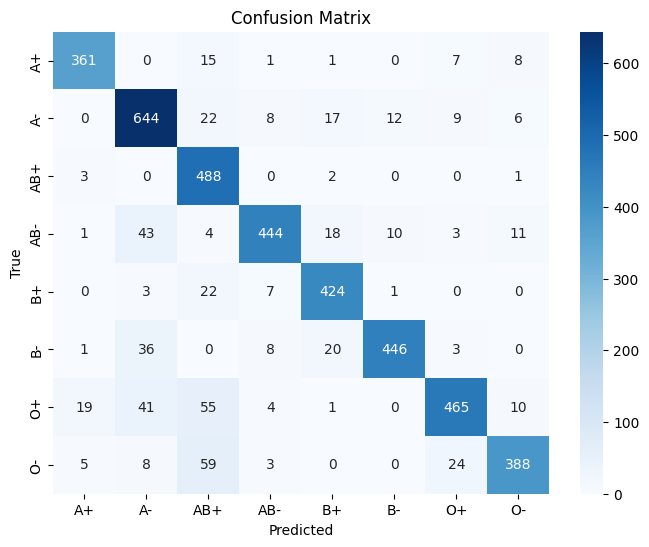

In [92]:
# Get predictions on the test dataset
y_true = []  # True labels
y_pred = []  # Predicted labels

# Iterate over the test dataset and collect the true and predicted labels
for images, labels in test:
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)  # Convert one-hot encoded predictions to class labels
    y_true.extend(labels.numpy())  # Convert tensor to numpy array and append
    y_pred.extend(predicted_labels)  # Append the predicted labels

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:")
print(report)

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [93]:
model.save('model.h5')